In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
from torch.utils.data import Dataset
from PIL import Image
class Mydata(Dataset):
    def __init__(self, root_dir, label_dir):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.path = os.path.join(self.root_dir, self.label_dir)
        self.img_path = os.listdir(self.path)
        
    def __getitem__(self,idx):
        img_name = self.img_path[idx]
        img_item_path = os.path.join(self.root_dir, self.label_dir, img_name)
        img = Image.open(img_item_path)
        label = self.label_dir
        return img, label
    
    def __len__(self):
        return len(self.img_path)

In [6]:
root_dir = 'data\\hymenoptera_data\\train'
ants_label_dir = 'ants'
bees_label_dir = 'bees'
ants_data = Mydata(root_dir,ants_label_dir)
bees_data = Mydata(root_dir,bees_label_dir)
train = ants_data + bees_data

In [7]:
root_dir = 'data/hymenoptera_data/val'
ants_data = Mydata(root_dir,ants_label_dir)
bees_data = Mydata(root_dir,bees_label_dir)
val = ants_data + bees_data

In [20]:
image_datasets = {'train':train, 'val':val}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Administrator/.cache\torch\checkpoints\resnet18-5c106cde.pth


Epoch 0/24
----------
train Loss: 0.6825 Acc: 0.6762
val Loss: 0.1759 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.4368 Acc: 0.7992
val Loss: 0.2473 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.5025 Acc: 0.7869
val Loss: 0.2388 Acc: 0.8954

Epoch 3/24
----------
train Loss: 0.3236 Acc: 0.8689
val Loss: 0.2590 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.8117 Acc: 0.7295
val Loss: 1.7900 Acc: 0.6732

Epoch 5/24
----------
train Loss: 0.6473 Acc: 0.7910
val Loss: 0.3654 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4359 Acc: 0.8443
val Loss: 0.4560 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.4658 Acc: 0.8033
val Loss: 0.2791 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3216 Acc: 0.8730
val Loss: 0.3129 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.4009 Acc: 0.8484
val Loss: 0.2903 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.2608 Acc: 0.8852
val Loss: 0.2707 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3147 Acc: 0.8484
val Loss: 0.2413 Acc: 0.9020

Ep

NameError: name 'class_names' is not defined

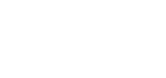

In [21]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

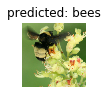

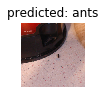

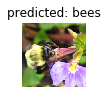

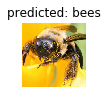

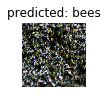

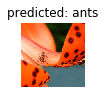

In [23]:
visualize_model(model_ft)

In [25]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [26]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6171 Acc: 0.6967
val Loss: 0.2398 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5426 Acc: 0.7295
val Loss: 0.5185 Acc: 0.8039

Epoch 2/24
----------
train Loss: 0.4411 Acc: 0.8156
val Loss: 0.5433 Acc: 0.7908

Epoch 3/24
----------
train Loss: 0.5849 Acc: 0.8033
val Loss: 0.2703 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.4637 Acc: 0.8074
val Loss: 0.2286 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.3406 Acc: 0.8279
val Loss: 0.2706 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.5238 Acc: 0.8156
val Loss: 0.1826 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.4280 Acc: 0.8074
val Loss: 0.2010 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3402 Acc: 0.8566
val Loss: 0.1834 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4037 Acc: 0.8402
val Loss: 0.1773 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3368 Acc: 0.8361
val Loss: 0.1935 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3070 Acc: 0.8607
val Loss: 0.1749 Acc: 0.9412

Ep

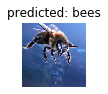

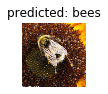

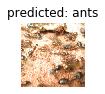

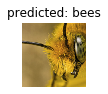

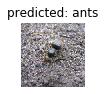

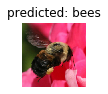

In [27]:
visualize_model(model_conv)
plt.ioff()
plt.show()